###                               Business Case :
    
    we have given a problem on the consumer grievances against Banks  
    
-Objective:
    create an analytical and modelling framework to predict the rating of the compliance management function of Banks as 
    outstanding/satisfactory/deficient based on the given data using the above criteria.
    
Depending on the analysis Banks can come to know which factors are influencing && improve the customer satisfaction

###       load required libraries

In [1]:
import pandas as pd
import numpy as np
import string
import re
import os
import nltk
from nltk.corpus import stopwords

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
import squarify # for tree maps
%matplotlib inline

In [4]:
init_notebook_mode(connected=True)

###     load data

In [3]:
data = pd.read_csv("GrievancesData_Train.csv")
data1= pd.read_csv("Train.csv")

#### Data Exploration

In [9]:
# check names of columns in data
data.columns

Index(['GrievanceID', 'BankID', 'State', 'DateOfGrievance',
       'Grievance_Category', 'GrievanceDescription', 'LineOfBusiness',
       'ResolutionComments', 'Disputed', 'DateOfResolution'],
      dtype='object')

In [20]:
data.shape

(53680, 10)

In [10]:
# check names of columns in data
data1.columns

Index(['BankID', 'BankGrade'], dtype='object')

In [21]:
data1.shape

(86, 2)

In [12]:
data.head(2)

,GrievanceID,BankID,State,DateOfGrievance,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,DateOfResolution
0,GID512411,Bank5279,State31,2016-01-19,Settlement process and costs,"Bank5279 Research dpt. \nXXXX XXXX XXXX XXXX,...",Mortgage,Closed with explanation,No,2016-01-30
1,GID512412,Bank5287,State26,2016-01-19,"Application, originator, mortgage broker",I had a mortgage with from XXXX of XXXX to XX...,Mortgage,Closed with explanation,Yes,2016-02-10


In [13]:
data1.head(2)

,BankID,BankGrade
0,Bank5298,satisfactory
1,Bank5421,deficient


In [5]:
train=pd.merge(data,data1,on='BankID')  ### mearging two data frames to train the model 

In [49]:
train.head(2)

,GrievanceID,BankID,State,DateOfGrievance,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,DateOfResolution,BankGrade
0,GID512411,Bank5279,State31,2016-01-19,Settlement process and costs,"Bank5279 Research dpt. \nXXXX XXXX XXXX XXXX,...",Mortgage,Closed with explanation,No,2016-01-30,outstanding
1,GID512415,Bank5279,State53,2016-01-19,"Loan servicing, payments, escrow account",Our Mortgage was sold to Bank5279 in XXXX of ...,Mortgage,Closed with explanation,No,2016-01-30,outstanding


In [34]:
train.shape

(53680, 11)

In [141]:
# check data types, non-null count in each field
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53680 entries, 0 to 53679
Data columns (total 11 columns):
GrievanceID             53680 non-null object
BankID                  53680 non-null object
State                   53559 non-null object
DateOfGrievance         53680 non-null object
Grievance_Category      53680 non-null object
GrievanceDescription    53680 non-null object
LineOfBusiness          53680 non-null object
ResolutionComments      53680 non-null object
Disputed                53680 non-null object
DateOfResolution        53680 non-null object
BankGrade               53680 non-null object
dtypes: object(11)
memory usage: 4.9+ MB


In [ ]:
#### cheching null values

In [188]:
train.isnull().sum()

GrievanceID               0
BankID                    0
State                   121
DateOfGrievance           0
Grievance_Category        0
GrievanceDescription      0
LineOfBusiness            0
ResolutionComments        0
Disputed                  0
DateOfResolution          0
BankGrade                 0
days                      0
dtype: int64

In [39]:
##### word count in Grievance description
train['word_count'] = train['GrievanceDescription'].apply(lambda x: len(str(x).split(" ")))
train[['GrievanceDescription','word_count']].head()

,GrievanceDescription,word_count
0,"Bank5279 Research dpt. \nXXXX XXXX XXXX XXXX,...",169
1,Our Mortgage was sold to Bank5279 in XXXX of ...,284
2,I was offered a trial modification by my serv...,210
3,Our Mortgage was sold to Bank5279 in XXXX of ...,284
4,My previous Mortgage Servicer sold my loan to...,366


In [158]:
###### stopwrds in Grievance Description
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['stopword'] = train['GrievanceDescription'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['GrievanceDescription','stopword']].head()

,GrievanceDescription,stopword
0,"Bank5279 Research dpt. \nXXXX XXXX XXXX XXXX,...",68
1,Our Mortgage was sold to Bank5279 in XXXX of ...,111
2,I was offered a trial modification by my serv...,71
3,Our Mortgage was sold to Bank5279 in XXXX of ...,111
4,My previous Mortgage Servicer sold my loan to...,170


In [160]:
train.head(2)

,GrievanceID,BankID,State,DateOfGrievance,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,DateOfResolution,BankGrade
0,GID512411,Bank5279,State31,2016-01-19,Settlement process and costs,"Bank5279 Research dpt. \nXXXX XXXX XXXX XXXX,...",Mortgage,Closed with explanation,No,2016-01-30,outstanding
1,GID512415,Bank5279,State53,2016-01-19,"Loan servicing, payments, escrow account",Our Mortgage was sold to Bank5279 in XXXX of ...,Mortgage,Closed with explanation,No,2016-01-30,outstanding


###     EDA && visualizations

In [50]:
train.BankGrade.value_counts()

satisfactory    34881
deficient       14304
outstanding      4495
Name: BankGrade, dtype: int64

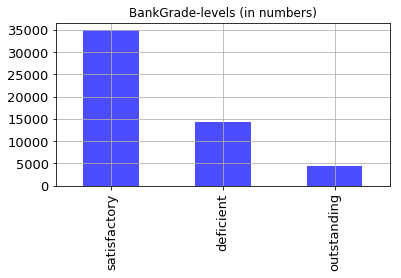

In [51]:
plt.figure()
train.BankGrade.value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('BankGrade-levels (in numbers)')
plt.grid()
plt.show()

In [ ]:
###  bank grade levels in percentage 

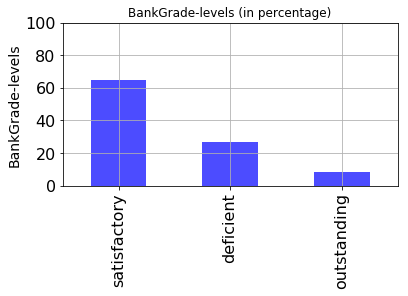

In [54]:
((train.BankGrade.value_counts()/sum(train.BankGrade.value_counts()))*100).plot(kind='bar',
                                  figsize=(6,3),
                                  color=["blue"],
                                  alpha = 0.7,
                                  fontsize=16)

plt.ylim([0,100])
plt.title('BankGrade-levels (in percentage)')
plt.ylabel('BankGrade-levels',fontsize = 14)
plt.grid(True)
plt.show()

In [190]:
train.ResolutionComments.value_counts()

Closed with explanation            41546
Closed with monetary relief         7029
Closed with non-monetary relief     4516
Closed                               589
Name: ResolutionComments, dtype: int64

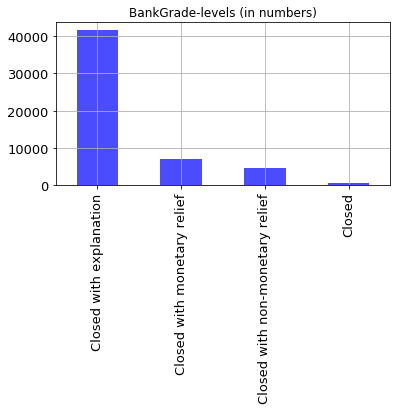

In [191]:
plt.figure()
train.ResolutionComments.value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('BankGrade-levels (in numbers)')
plt.grid()
plt.show()

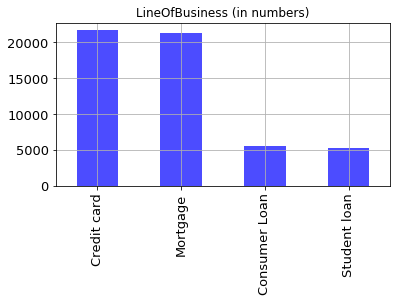

In [162]:
plt.figure()
train.LineOfBusiness.value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('LineOfBusiness (in numbers)')
plt.grid()
plt.show()

In [ ]:
##### maximum grievance categories

In [148]:
maxgrievancevategories=train['Grievance_Category'].value_counts()

In [78]:
maxgrievancevategories

Loan servicing, payments, escrow account                                            8455
Loan modification,collection,foreclosure                                            6469
Billing disputes                                                                    3645
Dealing with my lender or servicer                                                  3171
Managing the loan or lease                                                          2885
Other                                                                               2142
Identity theft / Fraud / Embezzlement                                               1951
Closing/Cancelling account                                                          1599
Application, originator, mortgage broker                                            1557
Trouble during payment process                                                      1342
Problems when you are unable to pay                                                 1170
Customer service / Cu

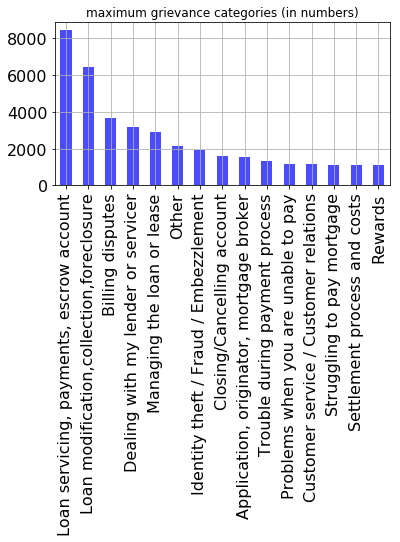

In [86]:
plt.figure()
maxgrievancevategories[maxgrievancevategories>1000].plot(kind='bar',figsize=(6,3),
                                  color=["blue"],
                                  alpha = 0.7,
                                  fontsize=16)
                                  
plt.title('maximum grievance categories (in numbers)')
plt.grid()
plt.show()

In [ ]:
######   changing into date format and calculating days 

In [168]:
from datetime import datetime

In [169]:
train['DateOfGrievance']=pd.to_datetime(train['DateOfGrievance'],format='%Y-%m-%d')
train['DateOfResolution']=pd.to_datetime(train['DateOfResolution'],format='%Y-%m-%d')

In [170]:
train['days']=train['DateOfResolution']-train['DateOfGrievance']
max(days)
min(days)


Timedelta('1 days 00:00:00')

In [172]:
temp = train.groupby(['days','Grievance_Category']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['days','Grievance_Category','Count']
temp

,days,Grievance_Category,Count
0,1 days,Charged fees or interest I didn't expect,2
1,2 days,Charged fees or interest I didn't expect,9
2,3 days,Charged bank acct wrong day or amt,3
3,3 days,Charged fees or interest I didn't expect,7
4,4 days,Charged fees or interest I didn't expect,3
5,4 days,Received a loan I didn't apply for,2
6,5 days,Charged fees or interest I didn't expect,9
7,6 days,Charged fees or interest I didn't expect,4
8,7 days,Charged fees or interest I didn't expect,6
9,8 days,Charged fees or interest I didn't expect,2


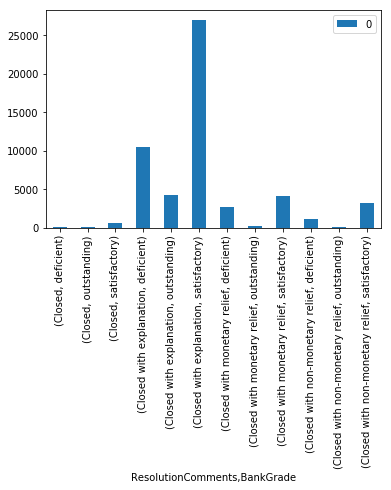

In [196]:
temp = train.groupby(['ResolutionComments','BankGrade']).size().to_frame()
temp.plot(kind='bar')

0
Disputed BankGrade          
No       deficient     10872
         outstanding    3831
         satisfactory  27192
Yes      deficient      3432
         outstanding     664
         satisfactory   7689

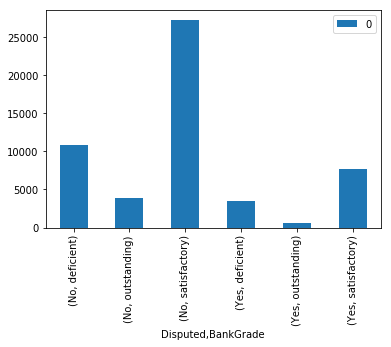

In [6]:
temp=train.groupby(['Disputed','BankGrade']).size().to_frame()
temp.plot(kind='bar')
temp

###   Text pre processing

In [9]:
import re
from nltk.corpus import RegexpTokenizer as regextoken
stop = stopwords.words('english')
lmtzr = nltk.stem.WordNetLemmatizer()
table = str.maketrans({key: None for key in string.punctuation})

def text_preprocessing(text):
    tokenizer = regextoken('\w+') # regular expression to select one or more word character
    text = re.sub(r'\s+', ' ', str(text)) # substitute one or more whitespace with one whitespace
    text = re.sub(r'[\d]', '', str(text)) # substitute occuerence of single
    text = text.translate(table) # remove punctuations
    sentences = nltk.tokenize.sent_tokenize(text)
    sentence_tokens = [tokenizer.tokenize(sentence) for sentence in sentences]
    # convert word to lower case and remove words that are part of nltk stop words
    tokens = [[word.lower() for word in sent if word not in stop] for sent in sentence_tokens] 
    tokens = [[lmtzr.lemmatize(word) for word in sent] for sent in tokens] # convert words to its root using lemmatization
    flattened_list = [y for x in tokens for y in x]
    token_refined = [word for word in flattened_list if len(word) > 1] # remove words with length 1
    string = str(' '.join(token_refined)) # join contents of list to form a continuous string
    return (string)

In [10]:
train['GrievanceDescription'] = train['GrievanceDescription'].apply(lambda x: text_preprocessing(x))

In [212]:
train['GrievanceDescription']

0        bank research dpt xxxx xxxx xxxx xxxx ca xxxxx...
1        our mortgage sold bank xxxx they bought xxxx x...
2        offered trial modification servicer bank accep...
3        our mortgage sold bank xxxx they bought xxxx x...
4        my previous mortgage servicer sold loan bank s...
5        xxxx xxxx xxxx transferred servicing loan xxxx...
6        xxxx year old female retired due decreased inc...
7        already placed complaint bank problem escrow a...
8        my wife home mortgage xxxx xxxx xxxx last year...
9        apparently mortgage sold bank servicing xxxx x...
10       xxxxxxxx xxxxxxxx tried make payment bank comp...
11       the servicing home mortgage transferred xxxx x...
12       in xxxxxxxx got divorced lost job lot trouble ...
13       in xxxx spoke bank mortgage arrange get curren...
14       my loan account transferred another mortgage c...
15       my mortgage transferred xxxx xxxx xxxx bank ll...
16       owned home since xxxx gone xxxx xxxx xxxx xxxx.

In [199]:
string =""
for sub_list in train['GrievanceDescription']:
    for i in sub_list:
        string=string+("").join(i)

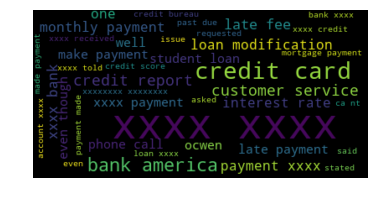

In [200]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=250,min_font_size=10, background_color="black").generate(string)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [330]:
train.head(2)

,GrievanceID,BankID,State,DateOfGrievance,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,DateOfResolution,BankGrade
0,GID512411,Bank5279,State31,2016-01-19,Settlement process and costs,bank research dpt xxxx xxxx xxxx xxxx ca xxxxx...,Mortgage,Closed with explanation,No,2016-01-30,outstanding
1,GID512415,Bank5279,State53,2016-01-19,"Loan servicing, payments, escrow account",mortgage sold bank xxxx bought xxxx xxxx xxxx ...,Mortgage,Closed with explanation,No,2016-01-30,outstanding


In [ ]:
### constructing TF-IDF matrix

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english', min_df=0.001)

# tokenize and build vocab
vectorizer.fit(train['GrievanceDescription'])

# encode document
vector = vectorizer.transform(train['GrievanceDescription'])

In [229]:
print(vector.shape)

(53680, 4157)


In [13]:
# convert sparse representation review-word matrix to dense representation
Dense_mat = vector.todense()
A = pd.DataFrame(Dense_mat, columns=vectorizer.get_feature_names())

In [230]:
A.shape

(53680, 4157)

### Build a model

In [ ]:
##### perform train and validation split

In [7]:
from sklearn.model_selection import train_test_split

In [14]:
# split data into train (70%) and validation (30%)
X_train, X_val, y_train, y_val = train_test_split(Dense_mat, train['BankGrade'], test_size=0.3, random_state=123)

In [233]:
X_train.shape, y_train.shape

((37576, 4157), (37576,))

In [234]:
X_val.shape, y_val.shape

((16104, 4157), (16104,))

In [235]:
y_train.value_counts()

satisfactory    24425
deficient       10020
outstanding      3131
Name: BankGrade, dtype: int64

In [236]:
y_val.value_counts()

satisfactory    10456
deficient        4284
outstanding      1364
Name: BankGrade, dtype: int64

In [ ]:
##### implementing Naive Bayes

In [341]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

In [342]:
clf_train = MultinomialNB()

clf_train.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [338]:
pred = clf_train.predict(X_val)

prediction = confusion_matrix(y_val, pred)

In [339]:
prediction

array([[1922,    0, 2362],
       [   8,  321, 1035],
       [ 944,    2, 9510]], dtype=int64)

In [340]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_val, pred)
print(acc)

0.7298186785891704


In [ ]:
##### prediction on test data

In [344]:
### loading test data
gr_test = pd.read_csv("GrievancesData_Test.csv")
sample_test=pd.read_csv("Test.csv")

In [356]:
test_bankid1=gr_test['BankID'].tolist()

In [357]:
len(test_bankid1)

27954

In [346]:
#test_bankid=list(set(test_bankid1))

In [343]:
# preprocess test data 
gr_test['GrievanceDescription'] = gr_test['GrievanceDescription'].apply(lambda x: text_preprocessing(x))

In [347]:
# encode document
test_vector = vectorizer.transform(gr_test['GrievanceDescription'])

In [348]:
test_Dense_mat = test_vector.todense()

In [350]:
pred_test = clf_train.predict(test_Dense_mat)

In [360]:
predicted=pd.DataFrame(pred_test,columns=['BankGrade'])

In [361]:
grade=predicted['BankGrade'].tolist()

In [362]:
len(grade)

27954

In [363]:
sub=pd.DataFrame({'BankGrade' :grade,'BankID' :test_bankid1},index=None,columns=['BankID', 'BankGrade'])

In [364]:
data=sub.groupby('BankID',as_index=False)

In [365]:
a=pd.DataFrame(data.first())

In [373]:
a

,BankID,BankGrade
0,Bank5246,deficient
1,Bank5259,deficient
2,Bank5271,satisfactory
3,Bank5272,satisfactory
4,Bank5278,satisfactory
5,Bank5284,satisfactory
6,Bank5299,satisfactory
7,Bank5310,satisfactory
8,Bank5312,satisfactory
9,Bank5316,satisfactory


In [366]:
a.to_csv('submission_2.csv',index=False)

In [388]:
train.head(2)

,GrievanceID,BankID,State,DateOfGrievance,Grievance_Category,GrievanceDescription,LineOfBusiness,ResolutionComments,Disputed,DateOfResolution,BankGrade
0,GID512411,Bank5279,State31,2016-01-19,Settlement process and costs,bank research dpt xxxx xxxx xxxx xxxx ca xxxxx...,Mortgage,Closed with explanation,No,2016-01-30,outstanding
1,GID512415,Bank5279,State53,2016-01-19,"Loan servicing, payments, escrow account",mortgage sold bank xxxx bought xxxx xxxx xxxx ...,Mortgage,Closed with explanation,No,2016-01-30,outstanding
